<font size = 6> **Анализ бизнес-показателей** </font>

Несколько прошлых месяцев бизнес (развлекательное приложение) постоянно нес убытки - в привлечение пользователей были вложены крупные маркетинговые бюджеты, которые не окупились. Для поиска причин неокупаемости маркетинга был проведен анализ причин сложившейся ситуации.

Среди данных для анализа есть лог сервера с информацией о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Цель проекта - изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

### Загрузка данных и подготовка их к анализу

#### Загрузка данных в переменные

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

#### Подготовка данных для анализа

После загрузки данных подготовим их для анализа и оптимизируем.

In [4]:
def preprocess_data(data):
    data.columns = [x.lower().replace(' ', '_') for x in data.columns.values]
    data.info()
    data.head()
    data.describe()
    display('Number of dublicated values')
    data.duplicated().sum()

##### Данные о визитах visits

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

* User Id — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Session start — дата и время начала сессии
* Session End — дата и время окончания сессии
* Channel — идентификатор рекламного источника, из которого пришел пользователь
* Region - страна пользователя

In [5]:
preprocess_data(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


'Missed values'

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

'Number of dublicated values'

0

Итак, столбцы были приведены к нужному формату snake-case, также препроцессинг данных показал отсуствие пропущенных значений и дубликатов.

Проверим, нет ли в датасете неверных данных (например, случаев, когда начало сессии больше конца сессии):

In [6]:
visits[visits['session_start'] > visits['session_end']]

,user_id,region,device,channel,session_start,session_end


Столбцы session_start и  session_end имеют неправильный тип данных, изменим его.

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Итак, датафрейм с данными о визитах (сессиях) был подготовлен к анализу.

##### Данные о заказах orders

Таблица orders_log_short (информация о заказах):

* User Id — уникальный id пользователя, который сделал заказ
* Event Dt — дата и время покупки
* Revenue — выручка

In [9]:
preprocess_data(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


'Missed values'

user_id     0
event_dt    0
revenue     0
dtype: int64

'Number of dublicated values'

0

Столбец event_dt приведем к типу данных datetime.

In [10]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Теперь данные о заказах готовы к анализу.

##### Данные о расходах costs

Таблица costs_short (информация о затратах на маркетинг):

* Channel — идентификатор рекламного источника
* Dt — дата
* Costs — затраты на этот рекламный источник в этот день

In [11]:
preprocess_data(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


'Missed values'

dt         0
channel    0
costs      0
dtype: int64

'Number of dublicated values'

0

In [12]:
costs['dt'] = pd.to_datetime(costs['dt'])

Теперь данные подготовлены для анализа - переименованы столбцы в более удобный вариант, также нужные данные преобразованы в необходимый тип.

Вывод: В распоряжении находятся три датафрейма - с данными о посещениях сайта, о заказах, о затратах на маркетинг. Сгруппируем здесь полное описание имеющихся данных:
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

  * User Id — уникальный идентификатор пользователя
  * Device — категория устройства пользователя
  * Session start — дата и время начала сессии
  * Session End — дата и время окончания сессии
  * Channel — идентификатор рекламного источника, из которого пришел пользователь
  * Region - страна пользователя

Таблица orders_log_short (информация о заказах):

   * User Id — уникальный id пользователя, который сделал заказ
   * Event Dt — дата и время покупки
   * Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

   * Channel — идентификатор рекламного источника
   * Dt — дата
   * Costs — затраты на этот рекламный источник в этот день

### Функции для расчета и анализа LTV, ROI, удержания и конверсии

#### Функция get_profiles() для построения профилей пользователей

In [14]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    
    if ad_costs is not None:
        #print(profiles.dtypes)
        #print(ad_costs.dtypes)
        #print(new_users.dtypes)
        
        # объединяем траты на рекламу и число привлечённых пользователей
        ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

        # делим рекламные расходы на число привлечённых пользователей
        ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

        # добавляем стоимость привлечения в профили
        profiles = profiles.merge(
            ad_costs[['dt', 'channel', 'acquisition_cost']],
            on=['dt', 'channel'],
            how='left',
        )

        # стоимость привлечения органических пользователей равна нулю
        profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles       

#### Функция get_retention() для расчёта удержания

In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция get_conversion() для расчёта конверсии

In [16]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция get_retention() для расчёта удержания

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция get_ltv() для расчёта LTV и ROI

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для визуализации

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Здесь построены пользовательские профили, определены минимальная и максимальная даты привлечения пользователей. Раздел разбит на несколько частей, подробно рассмотрены следующие аспекты:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

####  Создание пользовательских профилей. Определение минимальной и максимальной даты привлечения пользователей.

Для построения профилей пользователей вызовем функцию get_profiles() и передадим ей датафреймы с посещениями сайта (visits) и данные о заказах (orders).

In [23]:
profiles = get_profiles(visits, orders, None, None)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False
...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False


Пользовательские профили сгруппированы по уникальным пользователям и содержат данные о дате первого посещения, о рекламном канале, откуда был совершен первый переход, устройстве первого перехода и регионе привлечения. Также последний столбец содержит сведения о том, были ли совершены какие-либо покупки (т.е. платящий или неплатящий пользователь).

In [24]:
profiles['dt'].min() # YYYY-mm-dd

Timestamp('2019-05-01 00:00:00')

In [25]:
profiles['dt'].max()

Timestamp('2019-10-27 00:00:00')

Итак, минимальная дата привлечения пользователей - 1 мая 2019 г., а максимальная дата - 27 октября 2019 г. То есть анализ будет проведен внутри этих временных рамок (длительность - 6 месяцев).

#### Анализ данных по странам привлечения пользователей

Здесь рассмотрим, из каких стран приходят посетители, а также какие страны дают больше всего платящих пользователей.

In [26]:
def plot_profiles_by_variable(profiles, variable):
    
    # функция для построения общего графика динамики
    # количества пользователей по признаку
    profiles.pivot_table(
        index='dt',  # даты первых посещений
        columns=variable,  # изменяемая переменная
        values='user_id',  # ID пользователей
        aggfunc='nunique',  # подсчёт уникальных значений
    ).plot(figsize=(20, 7), grid=True, 
           #title = 
          )
 
    title_dict = {'region': 'странам',
                 'device': 'устройствам',
                 'channel': 'каналам'}

    plt.legend(loc='upper right')
    plt.title(f'Динамика количества привлеченных пользователей в разбивке по { title_dict[variable]}')
    plt.ylabel('Уникальных пользователей')
    plt.show()    

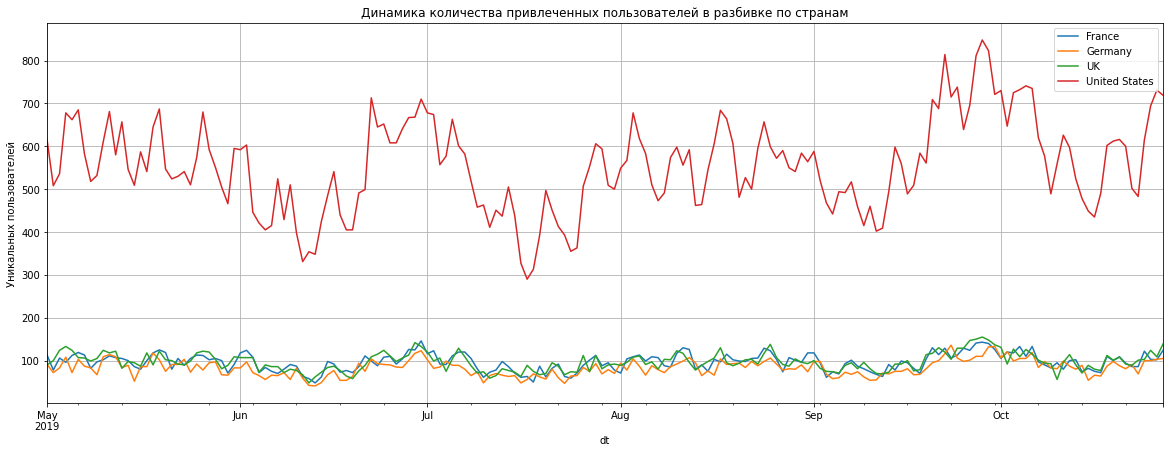

In [27]:
plot_profiles_by_variable(profiles, 'region')

Здесь мы видим, что больше всего посетителей приходит из США. Количество посетителей из Франции, Германии, Великобритании значительно ниже.

Для этого сгруппируем пользовательские профили по региону и посмотрим на среднее значение столбца payer (True/ False)

In [28]:
def profiles_by_variable(profiles, variable):
    
    #построение таблицы с долей платящих пользователей
    #группировка по признаку
    profiles_by_device = (
        profiles.groupby(variable).agg(
            {'user_id' : 'nunique', 
             'payer': ['sum', 'mean']})
    )
    
    profiles_by_device.columns = ['total_number_of_users', 
                                  'paying_ users', 
                                  'share_of_paying_users']
    
    profiles_by_device = profiles_by_device.sort_values(by = 'share_of_paying_users', ascending = False)
    
    display(profiles_by_device.style.format({'share_of_paying_users': lambda x: "{0:.3f}".format(x)}))
    
    #построение графика с долей платящих пользователей
    title_dict = {'region': 'странам',
                 'device': 'устройствам',
                 'channel': 'каналам'}
    profiles_by_device['share_of_paying_users'].plot(kind='bar', 
                                                     figsize=(8, 4), 
                                                     grid=True, 
                                                     fontsize=10, 
                                                     ec='black', 
                                                     color='gray',
                                                     legend = False,
                                                     #ylabel = '%'
                                                    )   
    
    plt.title(f'Доли платящих пользователей в разбивке по {title_dict[variable]}')
    plt.show()

,total_number_of_users,paying_ users,share_of_paying_users
region,,,
United States,100002,6902,0.069
Germany,14981,616,0.041
UK,17575,700,0.040
France,17450,663,0.038


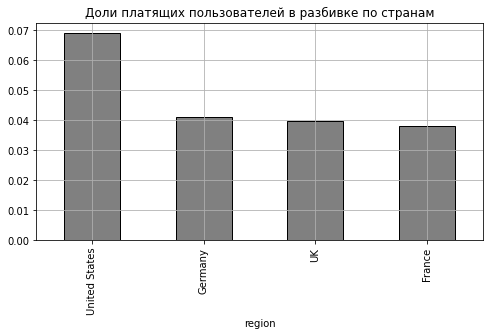

In [29]:
profiles_by_variable(profiles, 'region')

В качестве вывода можно сказать, что в целом больше всего пользователей приходит из США, а далее следуют другие страны. Такая же статистика по платящим пользователям - их также больше из США (7%), при этом доля платящих пользователей из других стран - около 4%.

#### Анализ данных по устройствам

Рассмотрим, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Ниже построена таблица, отражающая количество пользователей и долю платящих для каждого устройства.

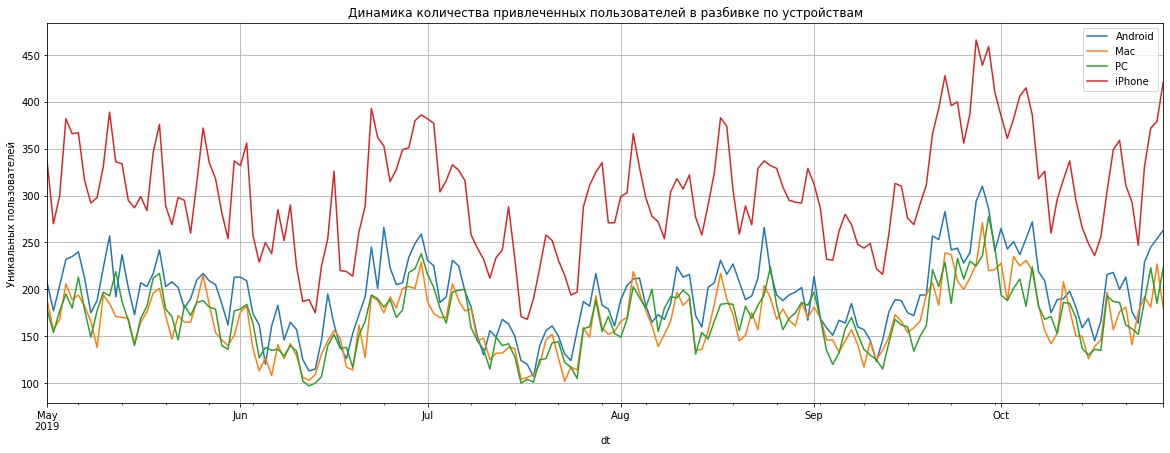

In [30]:
plot_profiles_by_variable(profiles, 'device')

Из графика видно, что сильно отрывается iPhone, остальные устойства уступают этому устройству.

,total_number_of_users,paying_ users,share_of_paying_users
device,,,
Mac,30042,1912,0.064
iPhone,54479,3382,0.062
Android,35032,2050,0.059
PC,30455,1537,0.050


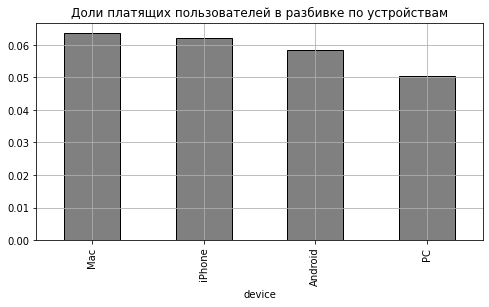

In [31]:
profiles_by_variable(profiles, 'device')

Больше всего пользователей приходит с устройства iPhone, но платящих пользователей больше с Mac (6,35%), доля IPhone ниже, но незначительно (6,2%). Доли платящих пользователей с Android и PC ниже.

#### Анализ данных по каналам привлечения пользователей

Проанализируем рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Ниже показаны графики и таблицы, отражающие количество пользователей и долю платящих для каждого канала привлечения.

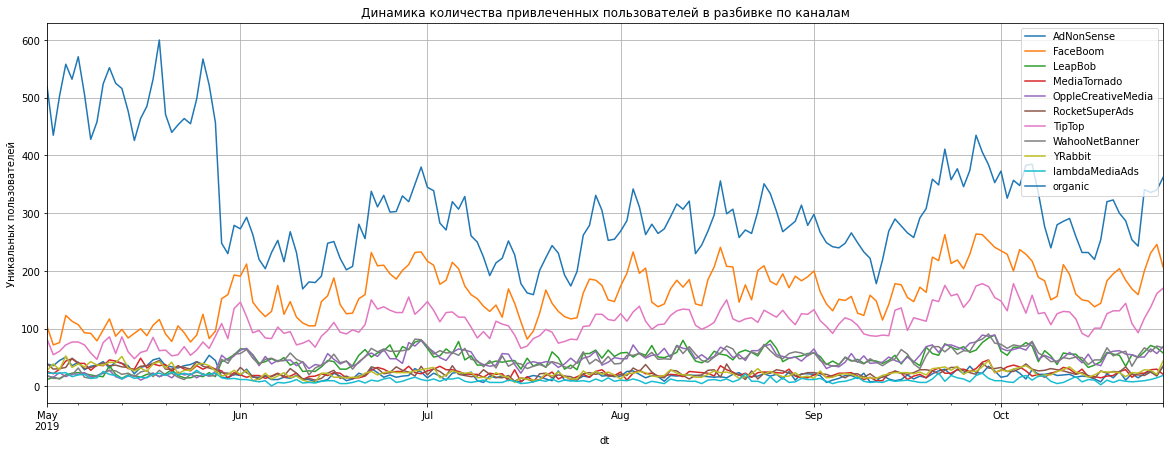

In [32]:
plot_profiles_by_variable(profiles, 'channel')

Данные графика показывают, что больше всего пользователей приходит через канал AdNonSense (при этом в первый месяц разрыв между этим источником и остальными был значительно выше). Начиная с июня 2019 г. выделились три лидирующих канала привлечения пользователей:
* AdNonSense,
* FaceBoom,
* LeapBob.
Далее следуют все остальные источники.

,total_number_of_users,paying_ users,share_of_paying_users
channel,,,
FaceBoom,29144,3557,0.122
AdNonSense,3880,440,0.113
lambdaMediaAds,2149,225,0.105
TipTop,19561,1878,0.096
RocketSuperAds,4448,352,0.079
WahooNetBanner,8553,453,0.053
YRabbit,4312,165,0.038
MediaTornado,4364,156,0.036
LeapBob,8553,262,0.031


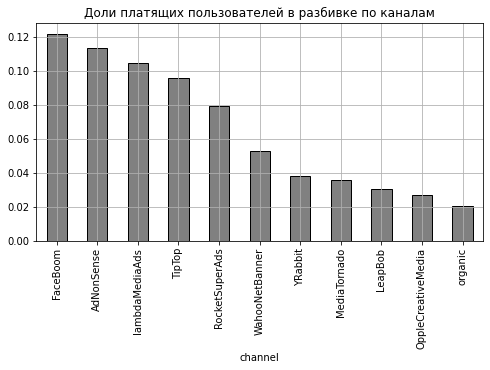

In [33]:
profiles_by_variable(profiles, 'channel')

Больше всего платящих пользователей приходит из источника FaceBoom (12%), далее следует AdNonSense (11%), lambdaMediaAds (10%) и другие. Меньше всего платящих пользователей приходит из organic (2%).

#### Выводы

Сделаем следующие предварительные выводы:
* **разбивка по странам**: больше всего посетителей приходит из США. Количество посетителей из Франции, Германии, Великобритании значительно ниже. Такая же статистика по платящим пользователям - их также больше из США (7%), при этом доля платящих пользователей из других стран - около 4%.

* **разбивка по устройствам**: больше всего пользователей приходит с устройства iPhone, но платящих пользователей больше с Mac (6,35%), доля IPhone ниже, но незначительно (6,2%). Доли платящих пользователей с Android и PC ниже.

* **разбивка по каналам**: больше всего пользователей приходит через канал AdNonSense. Но при этом больше всего платящих пользователей приходит из источника FaceBoom (12%), далее следует AdNonSense (11%), lambdaMediaAds (10%) и другие. Меньше всего платящих пользователей приходит из organic (2%). Возможно, самый популярный канал AdNonSense привлекает неплатящих пользователей, в таком случае вложения в него могут не приносить достаточно прибыли.

### Маркетинг

В этом разделе проведен анализ общего бюджета затрат на маркетинг, а также в разбивке по источникам и времени. Проведены расчеты стоимости привлечения одного пользователя из каждого источника.

#### Расчет общей суммы расходов на маркетинг. Распределение расходов по источникам. Визуализация изменения метрик во времени.

In [34]:
costs.head(10)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


In [35]:
round(costs['costs'].sum(),2)

105497.3

Всего расходов на маркетинг - 105 497 за рассматриваемый период.

In [36]:
costs_by_channel = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)
costs_by_channel

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


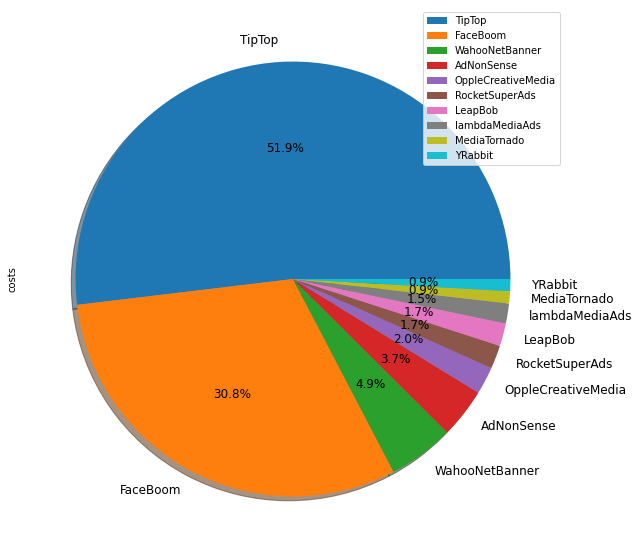

In [37]:
costs_by_channel.plot(kind='pie', 
                      y = 'costs',
                      figsize=(10, 10), 
                      subplots=True,
                      grid=True, 
                      fontsize=12,
                      autopct='%1.1f%%',
                      shadow = True
                     )
plt.show()

Больше половины расходов (51,9%) приходится на канал TipTop, который не является лидером привлечения платящих пользователей. Лидер по платящим пользователям - канал FaceBoom, но по расходам на него приходится только 30,8%. Также хорошие показатели привлечения платящих пользователей были у источника AdNonSense (а расходы на маркетинг по нему - лишь 3.7%).

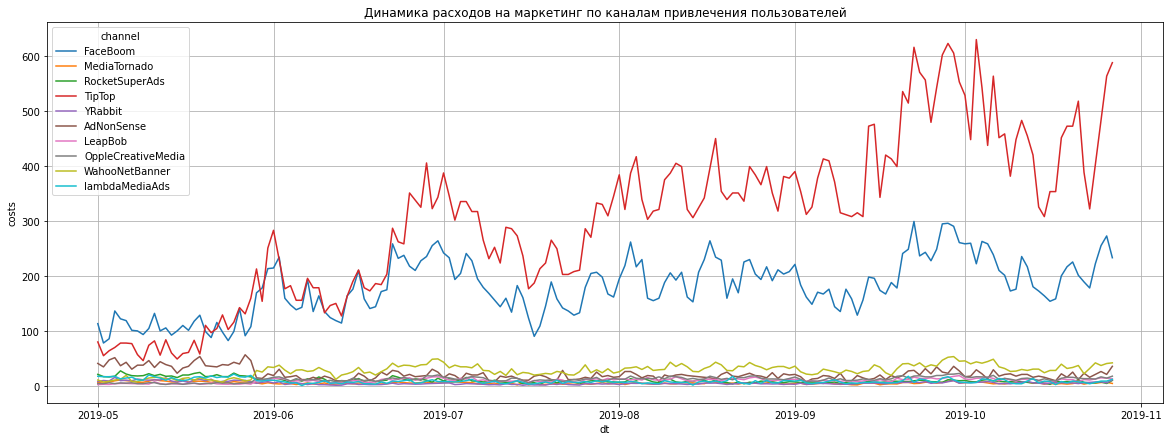

In [38]:
plt.figure(figsize=(20,7))
ax = plt.gca()
plt.grid(True)
sns.lineplot(data=costs, x='dt', y='costs', hue = 'channel', ax=ax)
plt.title('Динамика расходов на маркетинг по каналам привлечения пользователей')
plt.show()

Из графика видно, что с июля 2019 г. начинают возрастать расходы на канал привлечения TipTop, который не приносит много платящих пользователей (9% по предыдущим оценкам). Также отметим, что расходы в основном направлены в два канала - TipTop/ FaceBoom, остальные каналы сильно отстают.

In [39]:
costs_not_top = costs.query('channel != "TipTop" & channel != "FaceBoom"')

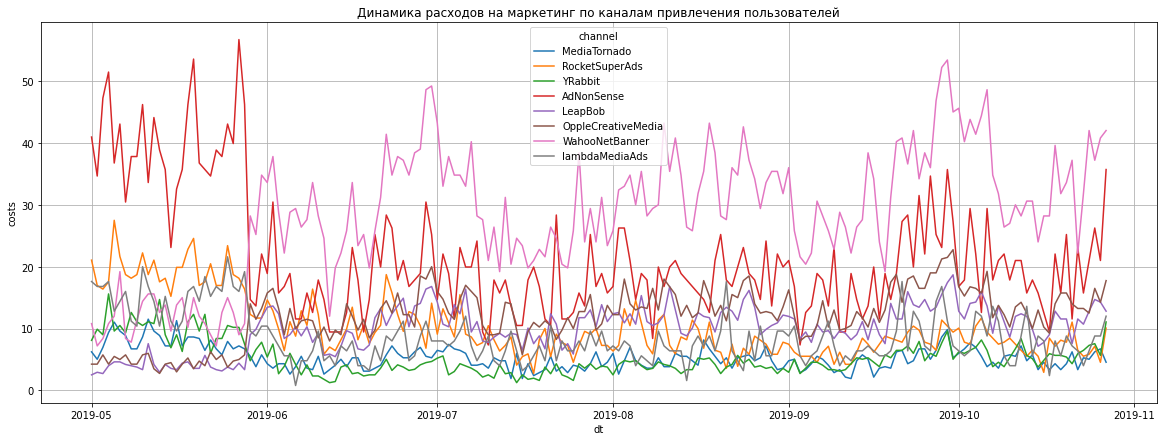

In [40]:
plt.figure(figsize=(20,7))
ax = plt.gca()
plt.grid(True)
sns.lineplot(data=costs_not_top, x='dt', y='costs', hue = 'channel', ax=ax)
plt.title('Динамика расходов на маркетинг по каналам привлечения пользователей')
plt.show()

Из графика видим снижение расходов по каналу AdNonSense, рост расходов по каналу WahooNetBanner.

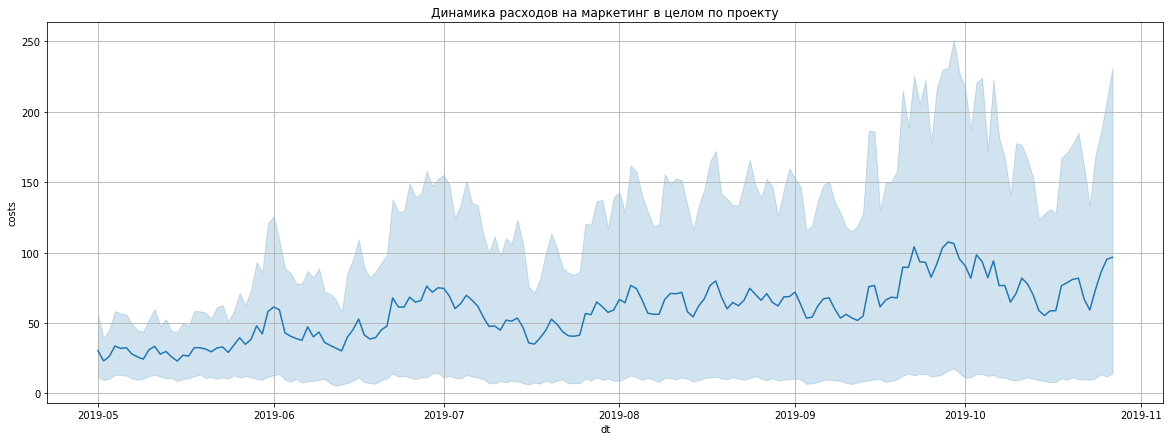

In [41]:
plt.figure(figsize=(20,7))
ax = plt.gca()
plt.grid(True)
sns.lineplot(data=costs, x='dt', y='costs', ax=ax)
plt.title('Динамика расходов на маркетинг в целом по проекту')
plt.show()

График показывает, что с течением времени растет сумма потраченных средств на маркетинг в разрезе по месяцам.

In [42]:
costs['month'] = costs['dt'].dt.month

In [43]:
costs_by_month = costs.groupby('month').agg({'costs': 'sum'}).sort_values(by = 'month')
costs_by_month

,costs
month,
5,9978.570
6,15090.045
7,16447.060
8,20657.870
9,22441.340
10,20882.415


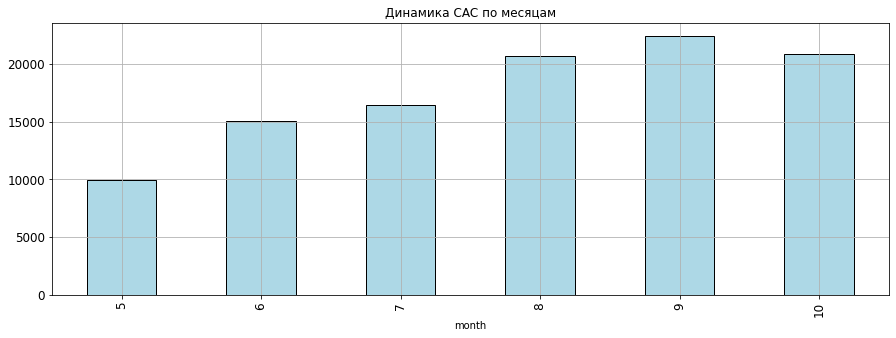

In [44]:
costs_by_month.plot(kind='bar', figsize=(15, 5), grid=True, fontsize=12, ec='black', color='lightblue',
                   legend = False,
                   title = 'Динамика CAC по месяцам')
plt.show()

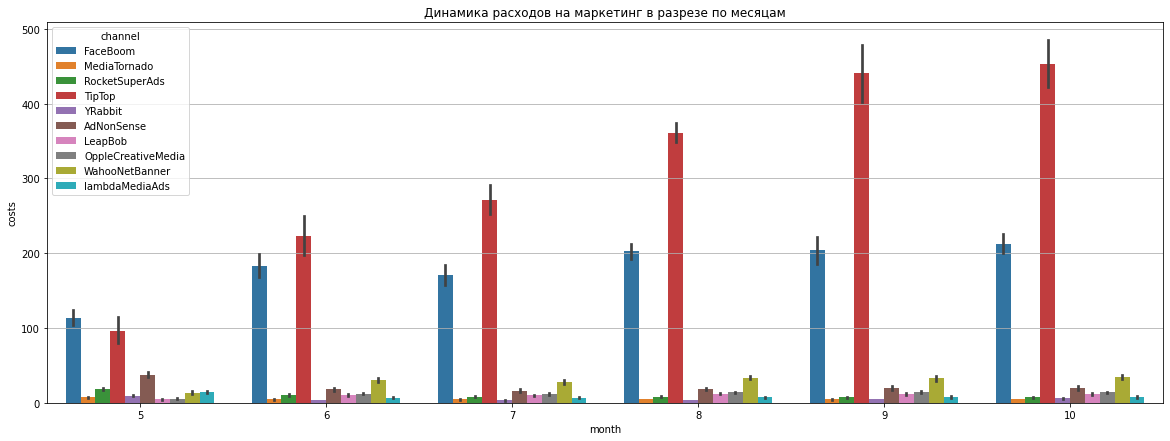

In [45]:
plt.figure(figsize=(20,7))
ax = plt.gca()
plt.grid(True)
sns.barplot(data=costs, x='month', y='costs', hue = 'channel', ax=ax)
plt.title('Динамика расходов на маркетинг в разрезе по месяцам')
plt.show()

In [46]:
del costs['month']

Из данного графика четко видно, как в помесячной разбивке возросли расходы по каналу TipTop по сравнению с другими каналами.

#### Анализ стоимости привлечения одного клиента из каждого источника. Расчет CAC на одного пользователя для всего проекта и для каждого источника трафика

Проанализируем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитайте средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используйте профили пользователей.

Customer Acquisition Cost — стоимость привлечения клиента. Формула расчёта метрики: CAC = расходы компании / количество полученных клиентов. В расходах можно учитывать как затраты на канал трафика, так и все траты компании — зарплату сотрудников, обслуживание оборудования и другие. Метрика помогает анализировать эффективность рекламы и прибыльность бизнеса.

Передадим таблицу с затратами на маркетинг в функцию get_profiles(), чтобы получить acquisition_cost.

In [47]:
profiles_cac = get_profiles(visits, orders, None, costs)
profiles_cac.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Посчитаем стоимость привлечения пользователей в целом по проекту, при этом не будем учитывать органических пользователей, так как их много, и компания не платит за их привлечение.

In [48]:
cac_total = profiles_cac.query('channel != "organic"')['acquisition_cost'].mean()
round(cac_total, 2)

1.13

Итак, стоимость привлечения в среднем по проекту (без учета органики) равна 1.13 $.

In [49]:
profiles_cac_by_channel = profiles_cac.groupby('channel').agg(
    {'user_id' : 'nunique',
     'acquisition_cost' : 'mean'
    }).sort_values(by='acquisition_cost', ascending=False)

profiles_cac_by_channel.columns = ['total_number_of_users', 'CAC, $']
profiles_cac_by_channel.style.format({'CAC, $': '{:.2f}'})

,total_number_of_users,"CAC, $"
channel,,
TipTop,19561,2.80
FaceBoom,29144,1.11
AdNonSense,3880,1.01
lambdaMediaAds,2149,0.72
WahooNetBanner,8553,0.60
RocketSuperAds,4448,0.41
OppleCreativeMedia,8605,0.25
YRabbit,4312,0.22
MediaTornado,4364,0.22


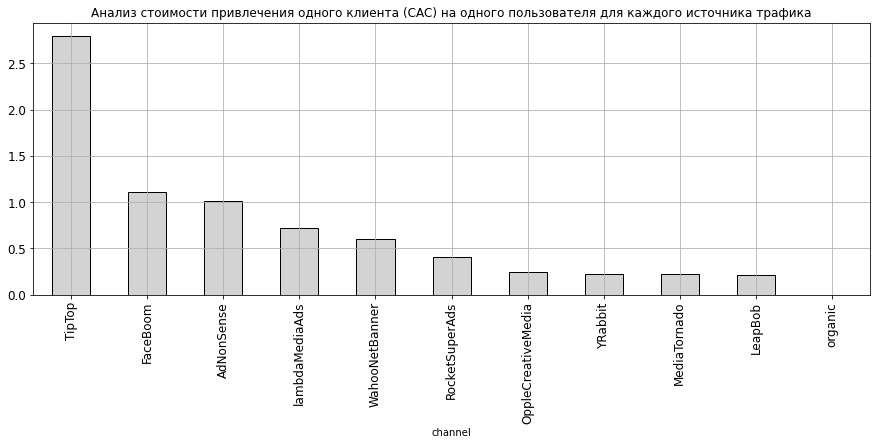

In [50]:
profiles_cac_by_channel['CAC, $'].plot(
    kind='bar', 
    figsize=(15, 5), 
    grid=True, 
    title = 'Анализ стоимости привлечения одного клиента (CAC) на одного пользователя для каждого источника трафика',
    fontsize=12, 
    ec='black', 
    color='lightgray')
plt.show()

Наиболее высокая стоимость привлечения пользователей - у канала TipTop (с отрывом - единственный канал с CAC выше среднего про проекту). Компания вкладывает в TipTop большие средства и привлекает неплатящих пользователей (доля платящих по данному каналу не является высокой). Нужно сократить рекламный бюджет на этот канал, либо перенастроить кампании, ввести стоп-слова ("бесплатный" и т.д.) - если возможно.
Далее следует FaceBoom, AdNonSense и др. 

### Оценка окупаемости рекламы для привлечения пользователей

####  Анализ общей окупаемости рекламы. Построение графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

In [51]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [52]:
profiles_cac.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Для дальнейшего анализа не будем учитывать органических пользователей, поэтому перезапишем датафрейм без их учета:

In [53]:
profiles_cac = profiles_cac.query('channel != "organic"')

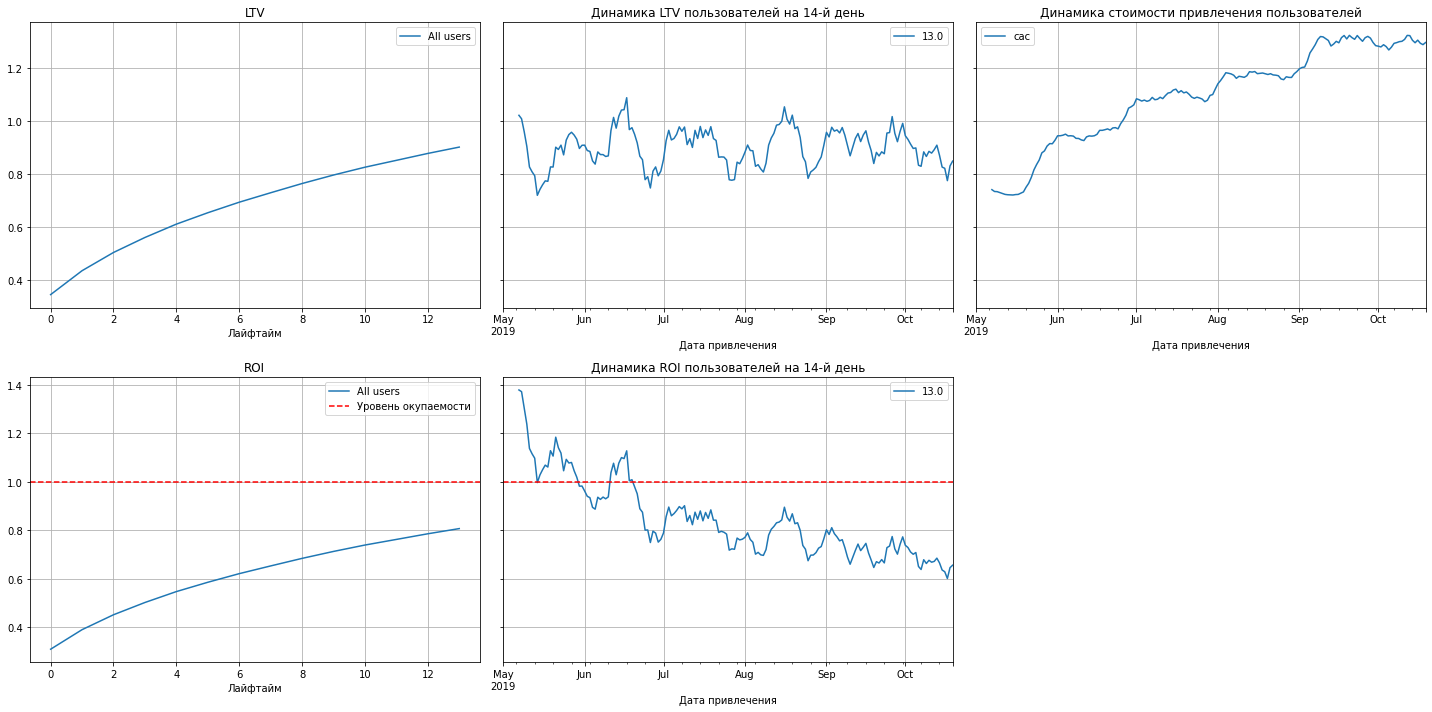

In [54]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_cac, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Вывод: 
* реклама не окупается - ROI приближается к 80% в конце периода исследования,
* показатель CAC стремительно растет на протяжении периода. Это подозртельный фактор - возможно рекламный бюджет расходуется нерационально. Опасная тенденция - в динамике ROI падает, а CAC растет.
* показатель LTV меняется, но здесь возможно имеет значение сезонный фактор.

#### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

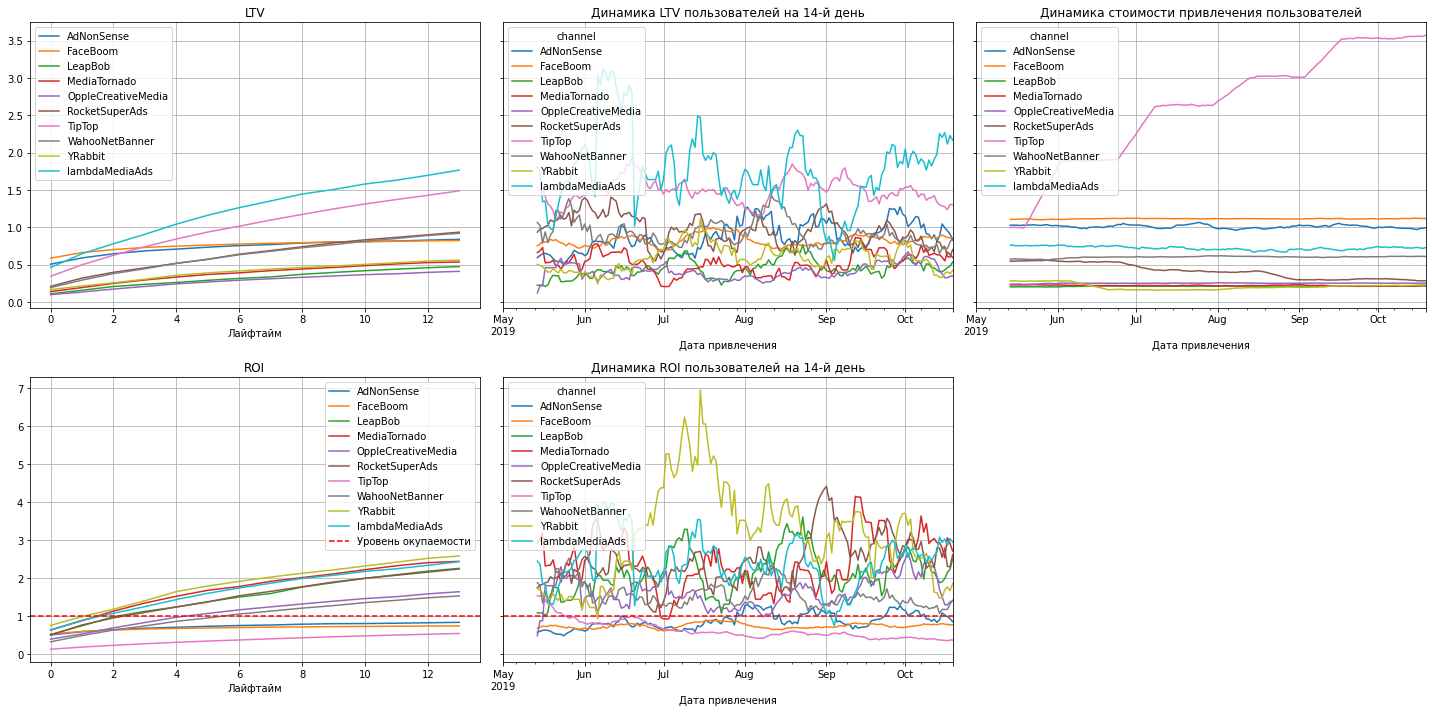

In [55]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Показатель CAC возрос значительно только по каналу TipTop (по остальным каналам CAC стабилен - как и должно быть). При этом реклама в TipTop не окупается! В динамике ROI по этому каналу падает. Также не окупается реклама в каналах FaceBoom, LeapBob. 

Решая комплексную задачу поиска причины неокупаемости маркетинга, разобьем составную проблему на частные причины, декомпозируя трафик по странам, устройствм, регионам для поиска момента, в который случилась проблема.

#### Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.


Опишем обнаруженные проблемы и напишем промежуточные выводы.

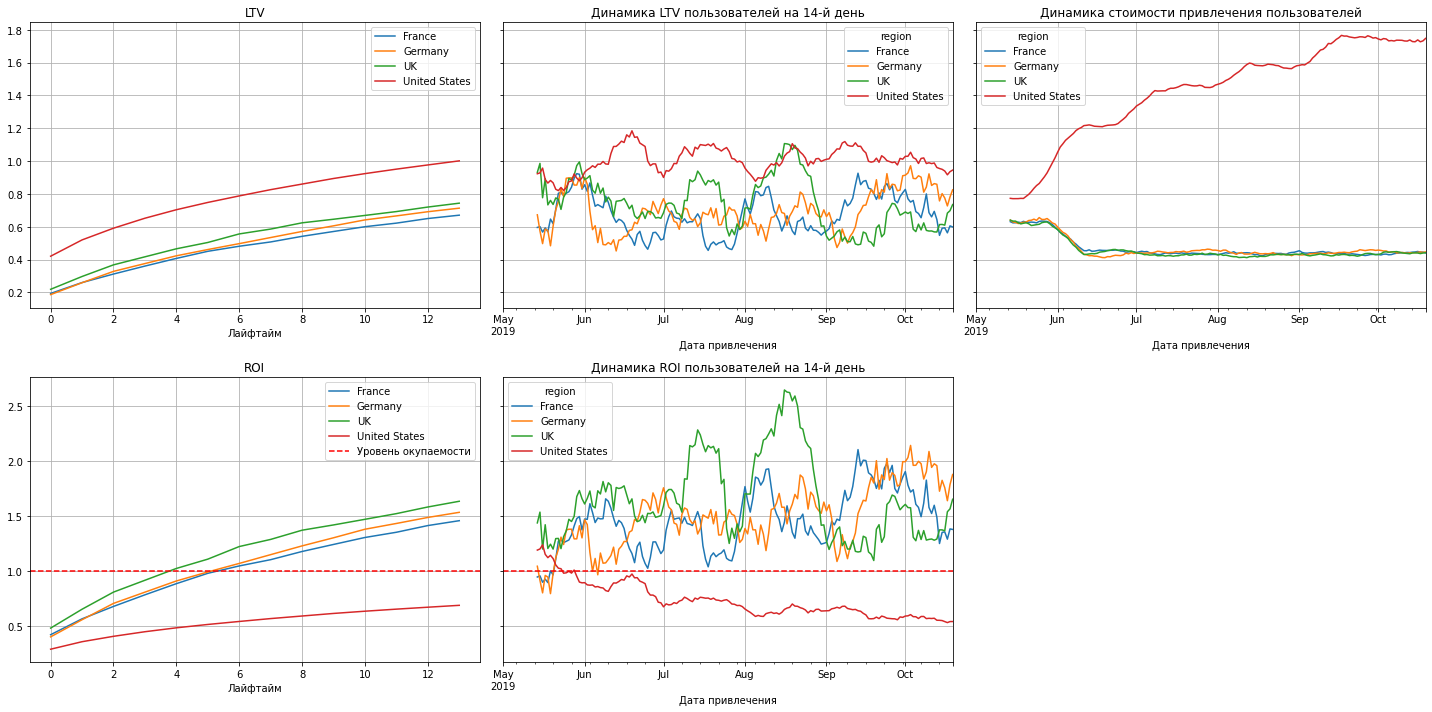

In [56]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Здесь мы видим, что растет стоимость привлечения пользователей из США, при этом реклама для пользователей США не окупается (ROI низкий и стремительно падает в динамике). Стоимость привлечения пользователей из остальных 3-х стран снижается с середины июня 2019 г.

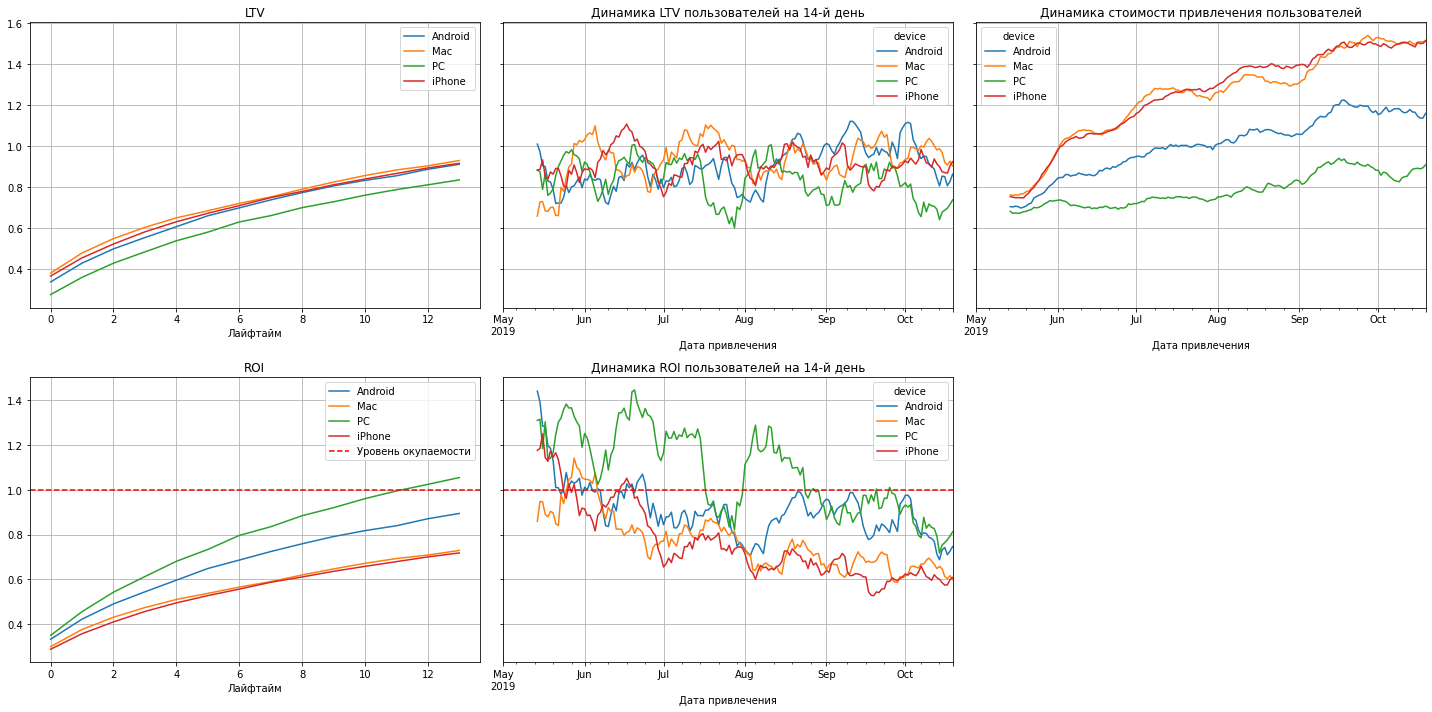

In [57]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Не окупается реклама для пользователей всех устройств, кроме PC. Стоимость привлечения же пользователей PC ниже, чем у других устройств. Но в динамике показатели ROI падают по всем устройствам. Декомпозиция помогла разобраться с LTV И ROI, получили явную проблему в US и TIp Top с Faceboom, при учете, что US - страна с наибольшим количеством пользователей, а Tip TOp и FaceBoom - крупнешие каналы для нас это важные находки, дальше с которыми стоит работать.

#### Постройте и изучите графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

Ответьте на такие вопросы:
* Окупается ли реклама в целом?
* Какие устройства, страны и каналы могут снижать окупаемость рекламы?
* Чем могут быть вызваны проблемы окупаемости?
* Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

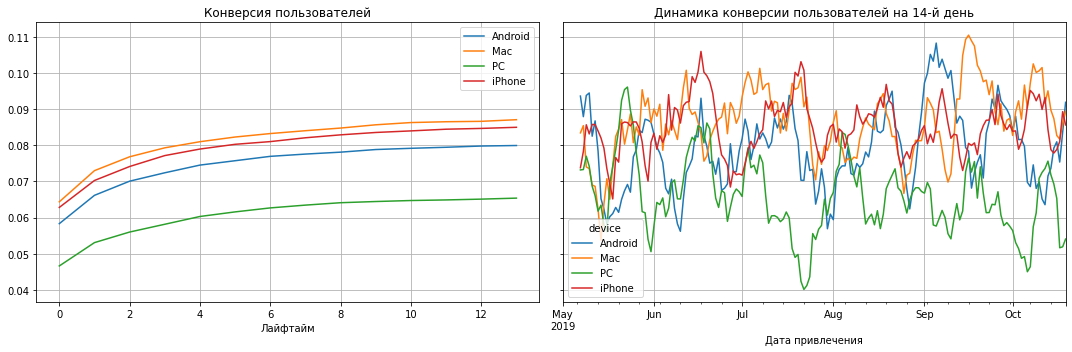

In [58]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Высокая конверсия у пользователей Mac, самая низкая - у PC. В динамике можно говорить о сезонном факторе в конверсии. Резкого снижения нет, но есть скачки.

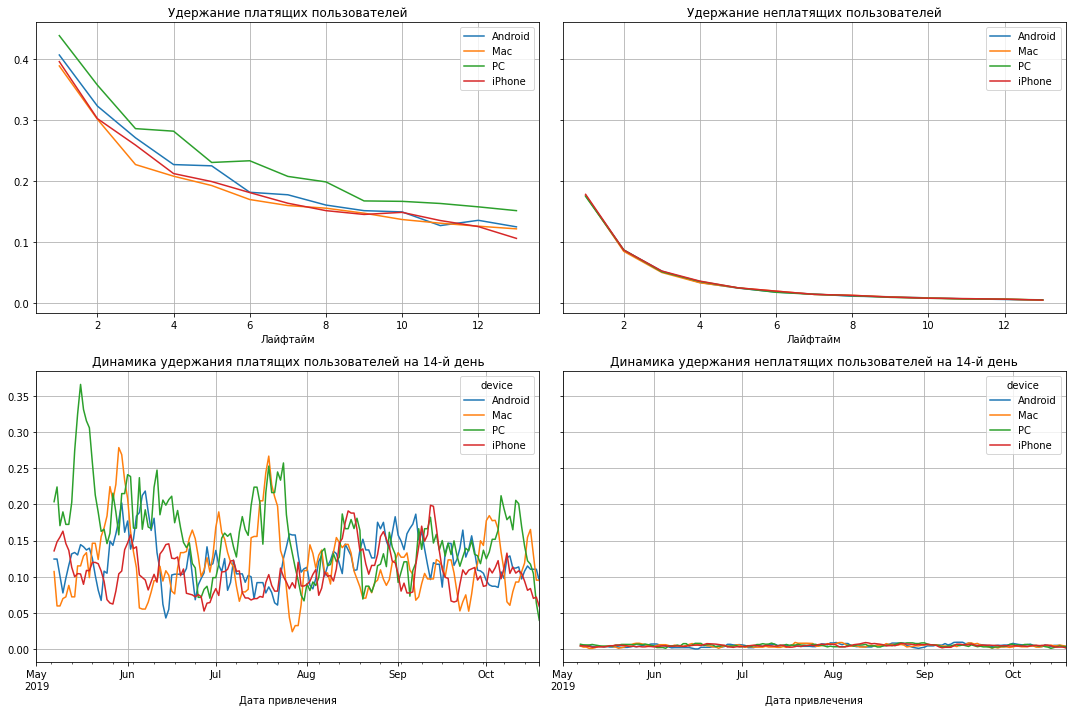

In [59]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание пользователей всех устройств стабильно снижается. Как ни странно, выше всего удержание у пользователей PC (хотя у них самая низкая конверсия). Возможно, пользуясь ПК, пользователи более внимательно изучают рекламу и выбирают интересный продукт. А со смартфонов совершают спонтанные покупки, далее быстро теряя интерес.

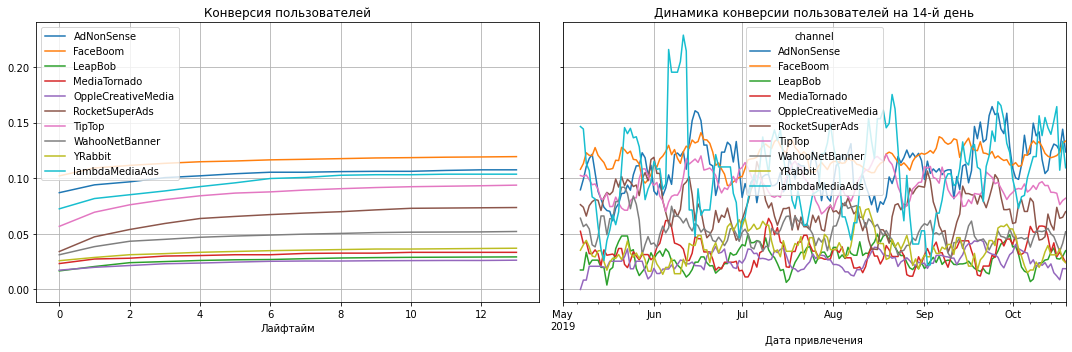

In [60]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наиболее высокая конверсия на канале Faceboom, хотя эта реклама не окупается. 

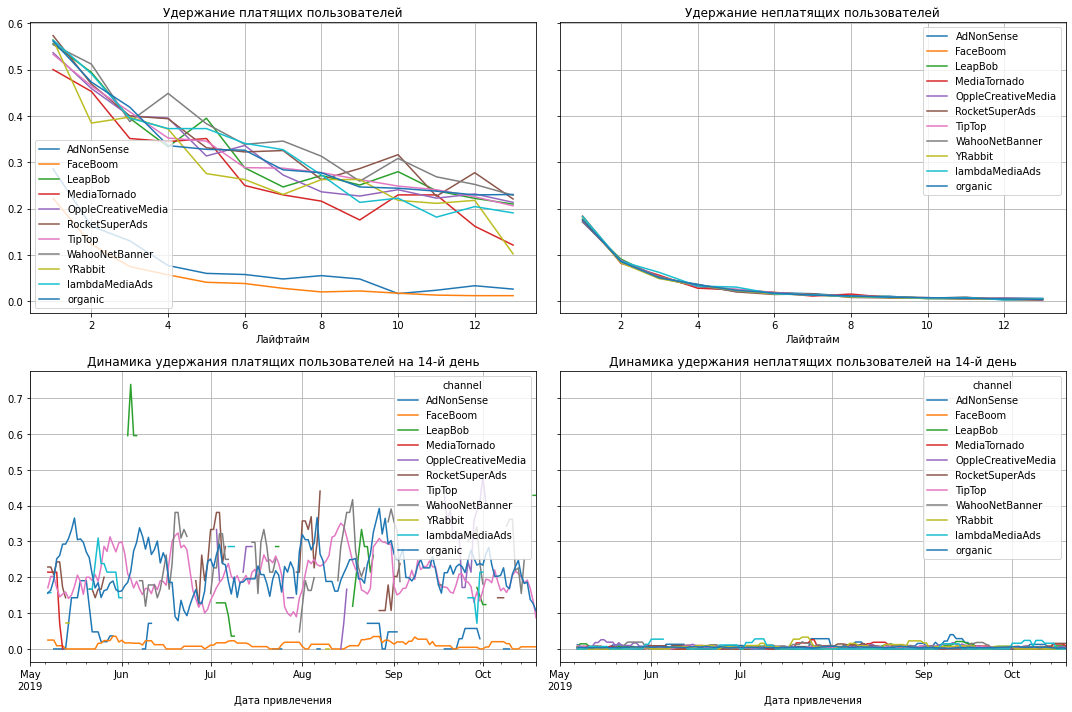

In [61]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Здесь видно, что очень низкое удержание у каналов AdNonSense, Faceboom, хотя они приносят много платящих пользователей. Проблема в том, что эти пользователи быстро теряют интерес к продукту и отскакивают.

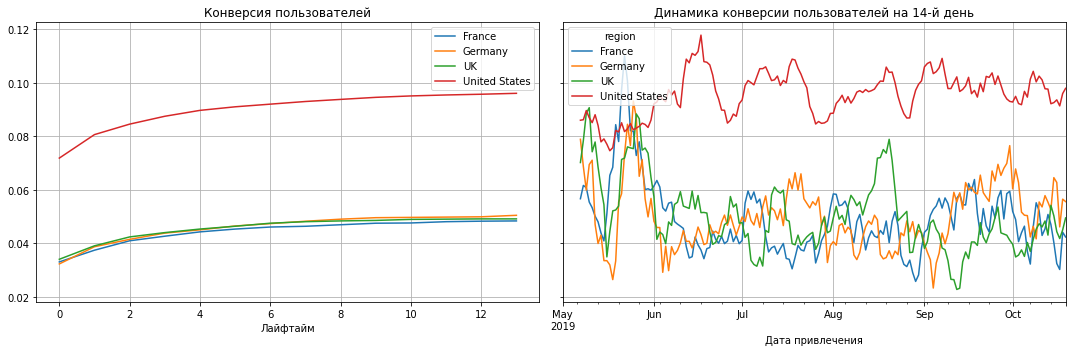

In [62]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

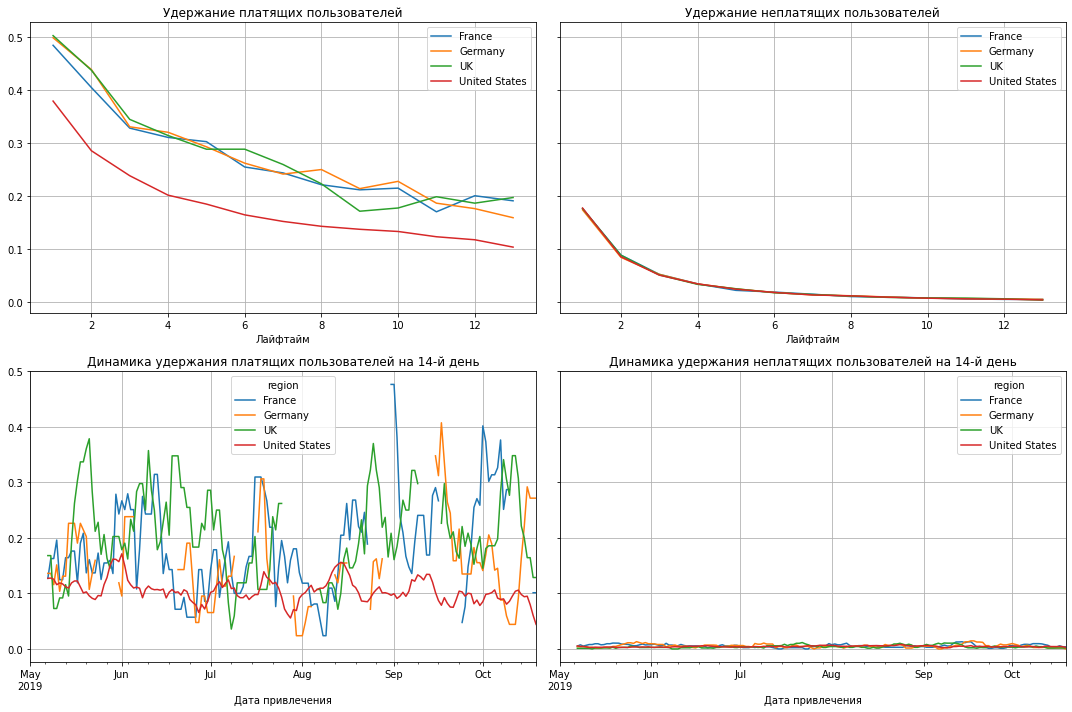

In [63]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Самая высокая конверсия - у пользователей США, но при этом у них же и самое низкое удержание. Основной проблемой является то, что реклама для США не окупается, поэтому рекомендуется настроить геотаргетинг с более активной рекламой в таких странах как Франция, Германия, Великобритания.

#### Причины неэффективности привлечения пользователей

Основная причина неэффективности - вкладывание бюджета в канал TipTop, который приносит не так много платящих пользователей, но при этом по нему стремительно растет CAC. 

#### Рекомендации для отдела маркетинга для повышения эффективности

Предлагается следующее:
  * перераспредить бюджет между каналами, срезать бюджет по каналам с недостаточным ROI, особенно по каналу TipTop. Также важно это сделать для канала FaceBoom, LeapBob. Увеличить бюджет на рекламные каналы с высоким ROI (например, YRabbit);
  * применить геотаргетинг и активнее рекламировать продукт среди пользователей Германии, Франции, Великобратинии,
  * активнее привлекать пользователей PC - у них выше удержание.